In [2]:
import pandas as pd
import numpy as np
from faker import Faker

# Initialize Faker for realistic data
fake = Faker()

# Generate mock claims data
np.random.seed(42)
n_entries = 10_000  # Simulate 10,000 claims

data = {
    "claim_id": [f"CLM_{i:05d}" for i in range(1, n_entries + 1)],
    "patient_id": [fake.uuid4() for _ in range(n_entries)],
    "provider_type": np.random.choice(
        ["Hospital", "Physician", "Nursing Facility", "Behavioral Health"], 
        size=n_entries,
        p=[0.4, 0.3, 0.2, 0.1]  # Weighted probabilities
    ),
    "service_date": [fake.date_between(start_date="-1y", end_date="today") for _ in range(n_entries)],
    "procedure_code": [fake.random_int(min=10000, max=99999) for _ in range(n_entries)],
    "cost": np.round(np.random.lognormal(mean=5, sigma=1, size=n_entries), 2),
    "denial_flag": np.random.choice([0, 1], size=n_entries, p=[0.85, 0.15]),  # 15% denial rate
    "state": np.random.choice(["CA", "TX", "NY", "FL"], size=n_entries)
}

claims_df = pd.DataFrame(data)
claims_df.to_csv("medicaid_claims_sample.csv", index=False)

In [3]:
import sqlite3

# Create SQLite database
conn = sqlite3.connect("medicaid_claims.db")
cursor = conn.cursor()

# Create table and import data
claims_df.to_sql("claims", conn, if_exists="replace", index=False)

# Example SQL query: Average cost by provider type
query = """
SELECT 
    provider_type,
    COUNT(*) AS total_claims,
    ROUND(AVG(cost), 2) AS avg_cost,
    ROUND(SUM(cost), 2) AS total_spend
FROM claims
GROUP BY provider_type
ORDER BY total_spend DESC;
"""

result = pd.read_sql(query, conn)
print(result)

       provider_type  total_claims  avg_cost  total_spend
0           Hospital          4058    252.71   1025498.19
1          Physician          3055    251.10    767100.04
2   Nursing Facility          1926    233.77    450250.47
3  Behavioral Health           961    239.12    229794.39


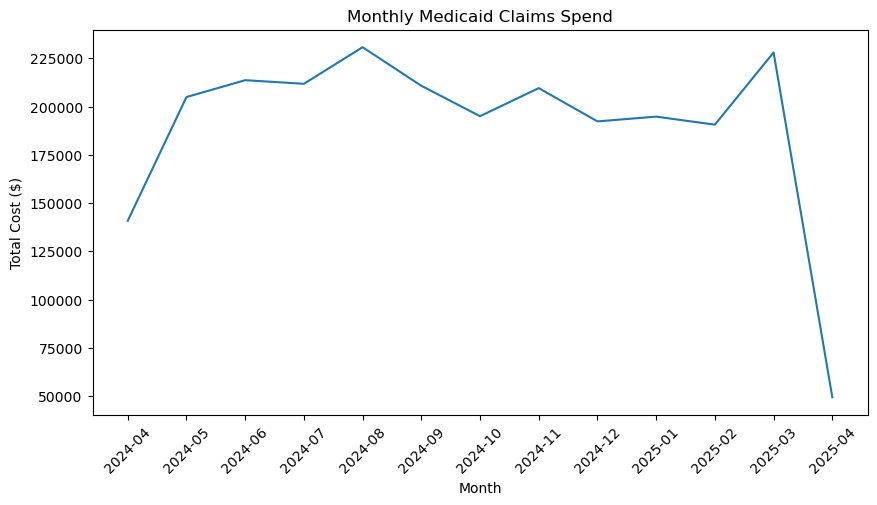

In [4]:
import matplotlib.pyplot as plt

# Monthly cost trends
claims_df["service_month"] = pd.to_datetime(claims_df["service_date"]).dt.to_period("M")
monthly_trends = claims_df.groupby("service_month")["cost"].sum().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(monthly_trends["service_month"].astype(str), monthly_trends["cost"])
plt.title("Monthly Medicaid Claims Spend")
plt.xlabel("Month")
plt.ylabel("Total Cost ($)")
plt.xticks(rotation=45)
plt.show()

In [5]:
# Identify high-cost outliers (top 5%)
threshold = claims_df["cost"].quantile(0.95)
outliers = claims_df[claims_df["cost"] > threshold]

print(f"Outliers (> ${threshold:.2f}): {len(outliers)} claims")

Outliers (> $774.06): 500 claims


In [6]:
# Simulate reimbursement rates based on provider type and state
reimbursement_rates = {
    "Hospital": 0.75,  # 75% of cost
    "Physician": 0.85,
    "Nursing Facility": 0.65,
    "Behavioral Health": 0.90
}

claims_df["reimbursement"] = claims_df.apply(
    lambda row: row["cost"] * reimbursement_rates[row["provider_type"]], axis=1
)

# Total simulated reimbursement
total_reimbursement = claims_df["reimbursement"].sum()
print(f"Total Reimbursement: ${total_reimbursement:,.2f}")

Total Reimbursement: $1,920,636.43
